In [3]:
import os
# file = os.path.join(os.getcwd(), 'data', 'LibriSpeech', 'dev-clean','84', '121123', '84-121123-0000.flac')
file ="C:\\Users\\Julio\\Documents\\Projects\\audio-denoiser\\data\\LibriSpeech\\dev-clean\\84\\121123\\84-121123-0000.flac"
testfile ="C:\\Users\\Julio\\Documents\\Projects\\audio-denoiser\\data\\test.wav"

import IPython.display as ipd

import numpy as np
ipd.Audio(filename=testfile)

In [4]:
import librosa
x, sr = librosa.load(testfile, sr=44100)
print('total length (S): ', x.shape[0]*(1/sr))

total length (S):  2.0353968253968255


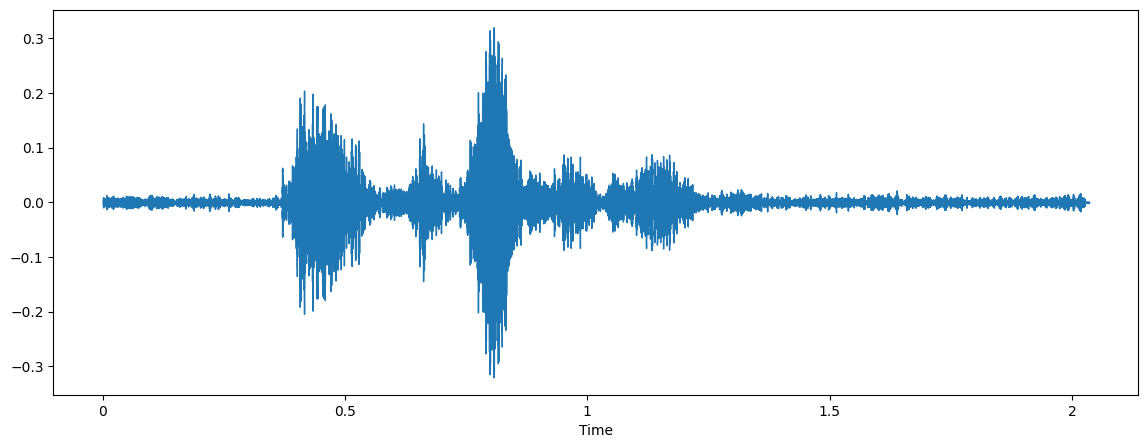

In [5]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

In [111]:
# window size: num of samples in a window
# n_fft: num of samples considered in the DFT for each sample in the window
    # usually they are the same
# hop_length: num of samples between the start of consecutive windows
    # 50% to 75% of n_fft overlap is common
# num of frequency bins = n_fft/2 + 1
    # more bins = more resolution in the frequency domain = more samples per FFT (narrowband)
    # range of bins is [0, sr/2]
    # wideband usually preferred for speech analysis
n_fft = 1024
X = librosa.stft(x, n_fft=n_fft, hop_length=512, center=False)
win_length_ms = 512/sr*1000
print('stft window length (ms): ', win_length_ms)
print('windows for 800ms: ', 800/win_length_ms)
print(X.shape)
print("total len: ", 512*(1+ X.shape[1])/sr)
print('total length (S): ', x.shape[0]*(1/sr))

stft window length (ms):  11.609977324263038
windows for 800ms:  68.90625
(513, 174)
total len:  2.0317460317460316
total length (S):  2.0353968253968255


In [96]:
# X_2 = librosa.util.normalize(X, axis=1)  # Normalize the magnitude
inverted_audio = librosa.istft(X, hop_length=512, win_length=1024)
ipd.Audio(x, rate=sr)


In [97]:
print(max(inverted_audio))
print(max(x))
print(inverted_audio.shape)
print(x.shape)

0.3201021
0.3201021
(88576,)
(89761,)


c:\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


numpy.complex64

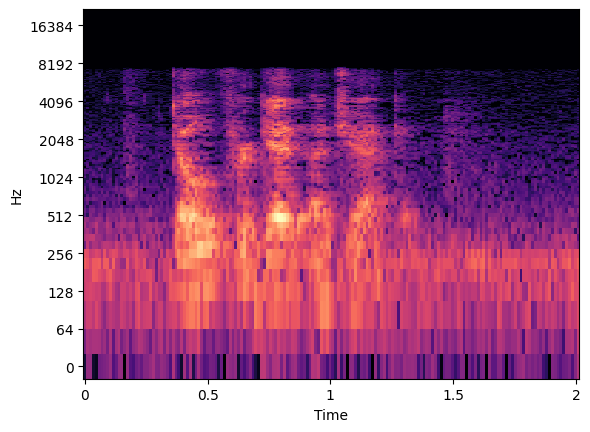

In [98]:
librosa.display.specshow(librosa.amplitude_to_db(X, ref=np.max), sr = sr, y_axis='log', x_axis='time')
Y = X
type(Y[0][1])


In [117]:
val = Y[5,:4]
print(val)
print(abs(val))
print(pow((val.real**2 + val.imag**2), 0.5))
print(np.real(np.conj(val)*val))
print (np.abs(val)**2)

[-0.6748957 +1.691181j    1.3626698 -0.49599436j -0.25360438-0.86511904j
  1.1751386 +1.2657568j ]
[1.8208727  1.4501308  0.90152436 1.7271627 ]
[1.8208725  1.4501308  0.90152436 1.7271627 ]
[3.315577   2.1028795  0.81274617 2.983091  ]
[3.3155773  2.1028793  0.81274617 2.983091  ]


In [29]:
# phase of val
phase = np.arctan2(val.imag, val.real)
phase

-0.15986265

In [35]:
val1 = Y[5][1]
val2 = Y[7][1]
print(val1 * val2)
_val = (val1.real*val2.real - val1.imag*val2.imag)+1j*(val1.real*val2.imag + val1.imag*val2.real)
print(_val)

(0.029063204-0.057134636j)
(0.029063204303383827-0.057134635746479034j)


In [ ]:
# Noise Estimation
# average past power spectra values on "silent" frames
# estimate_noise_ps(f,n) = alpha * estimate_noise_ps(f,n-1) + (1 - alpha) * noise_frame_ps(f,n)
# recursive defintion
# alpha is a smoothing factor [0,1], n is current frame and f is frequency bin from the stft

def smooth(signal_power, noise_estimate, alpha=0.9):
    return alpha * noise_estimate + (1 - alpha) * signal_power
    


In [110]:
'''
    1. Frame Goes through WF to get the smoothed noise estimate
    2. smoothed noise estimate is inverted and copied to calculate the next WF
    3. smoothed noise estimate is subtracted from noisy frame and invterted to calc next WF
    4. smoothed noise estimated subtracted from noisy frame to get enahnced frame
'''
    
class _AudioSuppressor:
    def __init__(self):
        self.alpha = 0.9
        self.noise_estimate = None
        self.thresh = 0.003
        self.noise_psd = 0
    # Y (k, n) k is frequency bin, n is frame
    # Y is mixed signal
    # X (k, n) is the estimated clean signal
    # N (k, n) is the estimated noise signal
    # N_smooth (k, n) is the smoothed noise estimate
    def __wiener_block(self, N_smooth, X_smooth):
        return None
    # def compute_filtered_output(self, current_frame):

    #     frame_energy = np.std(current_frame)**2


    #         # update wiener filter
    #         self.wiener_filt[:] = compute_wiener_filter(self.speech_psd,
    #                                                     self.noise_psd)
    #     else:   # speech frame

    #         s_i = current_frame

    #         # iteratively update speech power spectral density / wiener filter
    #         for i in range(self.iterations):
    #             a = lpc(s_i, self.lpc_order)
    #             g2 = compute_squared_gain(a, self.noise_psd, current_frame)
    #             self.speech_psd[:] = compute_speech_psd(a, g2, self.frame_len)

    #             # update Wiener filter
    #             self.wiener_filt[:] = compute_wiener_filter(self.speech_psd,
    #                                                         self.noise_psd)
    #             # update current frame with denoised version
    #             s_i = np.fft.irfft(self.wiener_filt * frame_dft)

    #     return self.wiener_filt * frame_dft
    def denoise(self, Y):
        # Y = np.abs(Y)
        # print('signal in ', Y)
        H = np.zeros(Y.shape)
        X = np.zeros(Y.shape)
        N = np.zeros(Y.shape)
        print(H.shape)
        
        
        for n in range(Y.shape[1]):
            Y_n = Y[:, n]
            # if n == 0:
            #     N_n = Y_n
            # else:
            #     N_n = 
            #
            
            y_n = x[n*n_fft:(n+1)*n_fft]
            frame_energy = np.std(y_n)**2
            print('frame energy: ', frame_energy)
            # Voice Activity Detection
            if frame_energy < self.thresh:
                # update noise power spectral density
                # assuming white noise, i.e. flat spectrum
                self.noise_psd = self.alpha * self.noise_psd +\
                                    (1 - self.alpha) * frame_energy
            # print(Y_n.reshape(Y.shape[0], 1))
            # print(y_n)
            # print(y_n1)
            # print(Y_n.shape)
        return None
AS = _AudioSuppressor()
Y = X[:, 0:10]
Y_clean = AS.denoise(Y)

(513, 10)
frame energy:  3.3938832097549785e-05
frame energy:  2.2327591024369356e-05
frame energy:  4.4041122116930155e-05
frame energy:  1.7302717733622824e-05
frame energy:  4.561085152482783e-05
frame energy:  3.1039183157786096e-05
frame energy:  1.1291555682851374e-05
frame energy:  1.4396485606435342e-05
frame energy:  1.971439643486464e-05
frame energy:  2.6018718389878882e-05


In [83]:
y = librosa.istft(Y[:,:2], hop_length=512, win_length=1024)
print(len(y))

# y = np.fft.ifft(abs(Y[:,0]))
print(y[:5])
print(x[:5])

512
[0.00226539 0.00231581 0.0019148  0.00140314 0.00110659]
[0.00226539 0.00231581 0.0019148  0.00140314 0.00110659]


In [ ]:
# Wiener Filter
# H_wiener = (signal_power - noise_power )/ signal_power 
# final signal power spectra is then H_wiener * signal_power
# the final spectra is combined with the phase of the original.

In [23]:
class AudioSuppressor:
    def __init__(self):
        self.alpha = 0.9
        self.noise_estimate = None
    # Y (k, n) k is frequency bin, n is frame
    # Y is mixed signal
    # X (k, n) is the estimated clean signal
    # N (k, n) is the estimated noise signal
    def denoise(self, Y):
        Y = np.abs(Y)
        print('signal in ', Y)
        for n in range(Y.shape[1]):
            Y_n = Y[:, n]
            print(Y_n.shape)
        return None
    
AS = _AudioSuppressor()
# print(X.shape)
Y = X[:, 0:10]
# print(Y.shape)
# librosa.amplitude_to_db(Y, ref=np.max)
# librosa.display.specshow(data=librosa.amplitude_to_db(Y, ref=np.max), sr = sr, y_axis='log', x_axis='time')
Y_clean = AS.denoise(Y)
    

(513,)
(10,)
(513,)
(10,)
(513,)
(10,)
(513,)
(10,)
(513,)
(10,)
(513,)
(10,)
(513,)
(10,)
(513,)
(10,)
(513,)
(10,)
(513,)
(10,)


In [7]:
def check(a, b):
    return a > b and a*(1-b) > b*(1-a)

check(1.5, 1)

True